# 1. 加载Overlay，定义DMA对象

In [10]:
from pynq import Overlay, allocate
import pynq.lib.dma

overlay = Overlay('./mnist_lstm.bit')  # 加载Overlay
dma = overlay.axi_dma_0  # 定义DMA对象

/usr/local/lib/python3.6/dist-packages/pynq/pl_server/device.py:594: UserWarning: Users will not get PARAMETERS / REGISTERS information through TCL files. HWH file is recommended.
  warnings.warn(message, UserWarning)
/usr/local/lib/python3.6/dist-packages/pynq/lib/dma.py:200: UserWarning: Failed to find parameter c_sg_length_width; users should really use *.hwh files for overlays.
  warnings.warn(message, UserWarning)


# 2. 解析MNIST测试集图片和标签数据

In [11]:
import read_mnist as reader
test_images = reader.load_images('data/t10k-images.idx3-ubyte')  # 读取测试集图片
test_labels = reader.load_labels('data/t10k-labels.idx1-ubyte')  # 读取测试集标签

magic number: 2051; image number: 10000; image size: 28px*28px
done
magic number:2049; image number: 10000
done


# 3. 从测试集中随机选取并显示若干图片

Image labels:  [2 0 3 3 4 5 6 9]


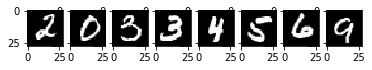

In [12]:
import random
import numpy as np
import matplotlib.pyplot as plt

IMG_NUM = 8

index = [0] * IMG_NUM
img = [0] * IMG_NUM
for i in range (IMG_NUM):
    index[i] = random.randint(0, 10000)  # 在测试集中随机选取8张图片
    img_dat = np.array(test_images[index[i]]).reshape(28, 28)

# 显示上面选取的8张测试图片
plt.figure()
for i in range (IMG_NUM):
    plt.subplot(1, IMG_NUM, i + 1)
    plt.imshow(np.array(test_images[index[i]]).reshape(28, 28),cmap='gray')
print('Image labels: ', test_labels[index])
plt.show()

# 4. RNN软件前向推导

In [13]:
import time
import ctypes as ctyp

net = ctyp.CDLL('./liblstm.so')  # 加载RNN软件动态库

img_vec = (ctyp.c_float * (28 * 28))()
res_vec = (ctyp.c_float * 10)()

sw_time = [0] * IMG_NUM
for i in range (IMG_NUM):
    t0 = time.time()
    for j in range(28*28):  # 归一化
        img_vec[j] = test_images[index[i]][j] / 255
    ifr_res = net.infer(img_vec, res_vec)  # 调用软件RNN进行推导
    t1 = time.time()
    sw_time[i] = t1 - t0
    print('Result: %d,' % ifr_res, 'time: {:1.6f}s'.format(sw_time[i]))

Result: 2, time: 0.398510s
Result: 0, time: 0.395251s
Result: 3, time: 0.396591s
Result: 3, time: 0.395784s
Result: 4, time: 0.395576s
Result: 5, time: 0.396025s
Result: 6, time: 0.395136s
Result: 9, time: 0.395780s


# 5. 利用IP核加速RNN推导，并计算加速比

In [14]:
hw_time = [0] * IMG_NUM
out_buf = allocate(shape=(10000, 10), dtype = np.float32)
for i in range (IMG_NUM):
    t0 = time.time()
    dma.sendchannel.transfer(test_images[index[i]])  # 调用DMA将待预测图片数据传输到IP核
    dma.recvchannel.transfer(out_buf[index[i]])  # 调用DMA从IP核获取RNN的推导结果
    dma.sendchannel.wait()  # 等待DMA发送完成
    dma.recvchannel.wait()  # 等待DMA接收完成
    t1 = time.time()
    hw_time[i] = t1 - t0

    out_list = np.array(out_buf[index[i]]).tolist()
    max_indx = out_list.index(max(out_list))  # 推导结果向量的最大分量的下标即为预测结果
    print('Result: %d,' % max_indx, 'time: {:1.6f}s'.format(hw_time[i]))
    
# 计算平均加速比
speed_up = [0.0] * IMG_NUM
for i in range (IMG_NUM):
    speed_up[i] = sw_time[i] / hw_time[i]
print('Average speedup: {:.3f}'.format(sum(speed_up) / IMG_NUM))

Result: 2, time: 0.281638s
Result: 0, time: 0.281376s
Result: 3, time: 0.281418s
Result: 3, time: 0.281421s
Result: 4, time: 0.281477s
Result: 5, time: 0.281421s
Result: 6, time: 0.281406s
Result: 9, time: 0.281385s
Average speedup: 1.407
